This is a multilabel classification task that output the degree of confidence `(probability)` a trained model has about a row of feature belonging to a particular class its trained on.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


text_lenght
count  10333.000000
mean      13.343076
std       19.077026
min        1.000000
25%        4.000000
50%        8.000000
75%       16.000000
max      467.000000

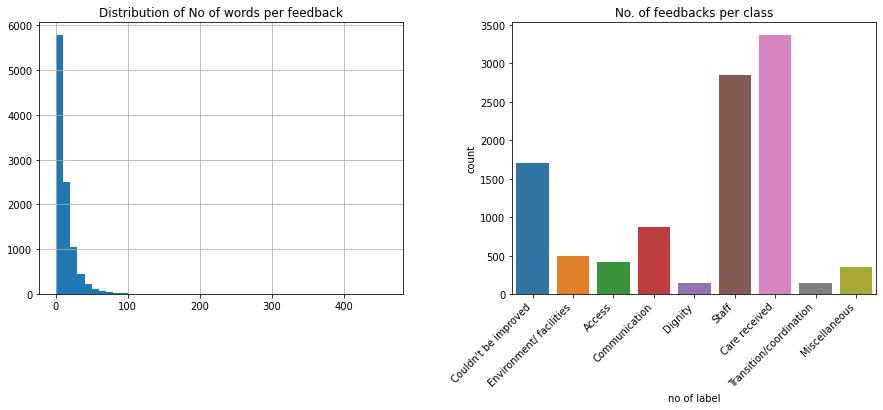

In [ ]:
# ==================================================== Exploratory Data Analysis ====================================================
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.dropna(inplace=True)

# # preprocess the data and split to train, test
no = len(df)
df['text_lenght'] = [len(x.split()) for x in df.feedback] 
texts = df[['feedback', 'text_lenght']][:no]

fig, ax = plt.subplots(1,2, figsize=(15,5))
df.hist(bins = np.arange(0,max(df.text_lenght),10), ax=ax[0])
ax[0].set(title='Distribution of No of words per feedback',)
sns.countplot(df.label, ax=ax[1]).set(xlabel='no of label', title='No. of feedbacks per class',)
plt.xticks(rotation = 45, ha='right')

df.describe()

In [111]:
# Define a function for evaluating the model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def class_balance_accuracy_score(y_true, y_pred):
    """
    Function for Class Balance Accuracy scorer
    (p. 40 in `Mosley 2013 <https://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=4544&context=etd>`_).
    copied from: `pxtextmining package <https://github.com/CDU-data-science-team/pxtextmining/blob/main/pxtextmining/helpers/metrics.py>`
    :param array y_true: True classes, shape = [n_samples].
    :param array y_pred: Predicted classes, shape = [n_samples].
    :return: cba (`float`): The Class Balance Accuracy score.
    """

    cm = confusion_matrix(y_true, y_pred)
    c_i_dot = np.sum(cm, axis=1)
    c_dot_i = np.sum(cm, axis=0)
    cba = []
    for i in range(len(c_dot_i)):
        cba.append(cm[i][i] / max(c_i_dot[i], c_dot_i[i]))
    cba = sum(cba) / (i + 1)
    return cba

In [ ]:
# single-label classification approach
#==================================================== Each row probabilities adds up to 1 ====================================================
%%time
import pandas as pd 
import numpy as np

!python -m spacy download en_core_web_md
import en_core_web_md as model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score 

# Load data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.dropna(inplace=True)

# # preprocess the data and split to train, test
nlp = model.load()
no = len(df)
# text_lenght = [len(x.split()) for x in df.feedback][:no]
# text_lenght= np.reshape(text_lenght, (-1,1)) 
texts = np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in df.feedback])[:no]
# features = np.concatenate((texts, text_lenght), axis=1)                                 #Model does better without the additional feature (text_lenght)
features = texts
le = LabelEncoder().fit(df.label)    # create the label encoder object(needed for converting our prediction back to the text labels)
labels = le.transform(df.label)[:no]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=0, stratify=labels) # create validation set

# Instantiate a spacy nlp object with your chosen model
nlp = model.load()
# x_train.feedback = np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in x_train.feedback])
# x_test.feedback = np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in x_test.feedback])

# Instantiate a model object and train the model
cls = LogisticRegression().fit(x_train, y_train)
pred_prob = cls.predict_proba(x_test)

# Evaluation the model
pred = np.argmax(pred_prob, axis=-1)
print('='*20) 
print(f'Model Accuracy is {accuracy_score(y_test, pred)}') 
print(f'Model Bal Accuracy is {balanced_accuracy_score(y_test, pred)}') 
print('='*20)

# Apply model on full data
print('\nPredicting on full dataset')
# texts.feedback = np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in texts])
all_pred_prob = cls.predict_proba(features)

# Single labeling
all_pred = [int(v) for v in np.argmax(all_pred_prob, axis=-1)]
print(f'Overall model Accuracy is {accuracy_score(labels, all_pred)}')
print(f'Overall Model Bal Accuracy is {balanced_accuracy_score(labels, all_pred)}') 
# df['pred_label'] = le.inverse_transform(all_pred) 

# Output Probability value for each label
col = le.inverse_transform(list(set(labels)))
for i,p in enumerate(all_pred_prob):        # Ge the row index and label probabilities of each row
    df.loc[i,col] = [round(v,3) for v in p]             # Assign the rounded probability to its label (this is directly possible because the probalities is arrange in aphebetical order of the unique values of the label)

print('\nAll Done\n')
print(max(df.iloc[:, -9:].sum(axis=1)))      # To confirm that the probabilities across each row roughly add up to 1
df.head(20)

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=e1e3968174c1ee4220d1299dc0e7a582f7644f51b06d90cdb546d10015cc1afd
  Stored in directory: /tmp/pip-ephem-wheel-cache-_22oz5pf/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy is 0.6816642477019835
Model Bal Accuracy is 0.4500516064499671

Predicting on full dataset
Overall model Accuracy is 0.707732507500242
Overall Model Bal Accuracy is 0.4926483519269103

All Done

1.0030000000000001
CPU times: user 2min 43s, sys: 3.26 s, total: 2min 46s
Wall time: 3min 14s


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

Training the Model
... Processing Access
Test accuracy is 0.9610085019055995
all data accuracy is 0.9623572672730791
... Processing Care received
Test accuracy is 0.7936089123424216
all data accuracy is 0.8250435455777047
... Processing Communication
Test accuracy is 0.9340369393139841
all data accuracy is 0.9378749758080124
... Processing Couldn't be improved
Test accuracy is 0.9416593374377016
all data accuracy is 0.9466808592994
... Processing Dignity
Test accuracy is 0.9850483729111698
all data accuracy is 0.9866460228372363
... Processing Environment/ facilities
Test accuracy is 0.9639401934916447
all data accuracy is 0.9618734275208051
... Processing Miscellaneous
Test accuracy is 0.9742011140428027
all data accuracy is 0.973582349525837
... Processing Staff
Test accuracy is 0.8501905599530929
all data accuracy is 0.8708147861428295
... Processing Transition/coo

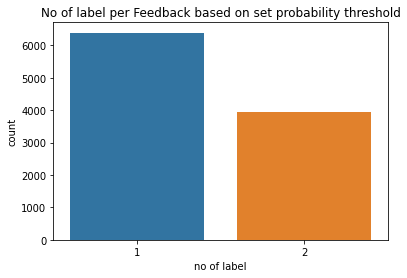

In [112]:
# Multi-label classification approach
#==================================================== Each row probabilities don't neccesarily add up to 1 ====================================================
%%time
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_word = set(stopwords.words('english'))
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import seaborn as sns

# Load in the data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.feedback.fillna('', inplace=True)

# Preprocess the single labelled dataset into a multilabel dataset and split the data into train and test set 
lb = LabelBinarizer().fit(df.label)
le = LabelEncoder().fit(df.label)    # create the label encoder object(needed for converting our prediction back to the text labels)
classes = lb.transform(df.label)
class_df = pd.DataFrame(classes, columns=lb.classes_)
df = pd.concat([df, class_df], axis=1)

train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.feedback
X_test = test.feedback

# Define a pipeline combining a text feature extractor with multi lable classifier
LogReg_pipeline = Pipeline([
               ('tfidf', TfidfVectorizer(stop_words=stop_word)),
               ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
               ])

print('\nTraining the Model')
for category in lb.classes_:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))   # explore the model performance on the test data
    
    # print('\nPredicting probability on full dataset')
    all_prediction = LogReg_pipeline.predict(df.feedback)
    print('all data accuracy is {}'.format(accuracy_score(df[category], all_prediction))) # explore the model performance on all the data
    probs = LogReg_pipeline.predict_proba(df.feedback)[:,1]    # keep the probabilities for class 1
    df[category] = probs                      # extract the probabilities for label 1 = represent that the row belongs to the specified class
    print('='*40)

# Extract all probability as an array
all_pred_prob = df.iloc[:, -9:].values

# Multi-label prediction on the full dataset
print('\nPredicting for Multilabeling') 
high = 0.5
multilabel_counter = 0
label_counter = []
multilabel_rowindex = []
for i, p in enumerate(all_pred_prob): # itererate over each row 
  # set the threshold to be either high or the seventy-fifth percentile   
  seventh = np.percentile(p, [75]) 
  if max(p) > high:
    threshold = high
  else:
    threshold = seventh
  best_labels_dict = {k:v for k,v in enumerate(p) if v>threshold}    # extract  as a dictionary the index and values of probaility greater than the threshold percentage
  best_labels_id = sorted(best_labels_dict, key=best_labels_dict.get, reverse=True) # Extract the label code(best_labels_dict.keys) arranged in decreasing order of their probability values
  best_label = le.inverse_transform(best_labels_id)                  # convert the label code into the original class names   
  label_counter.append(len(best_label))      
  df.loc[i,'multi_label'] = ', '.join(best_label)

  if len(best_label) > 1:
      multilabel_counter+=1
      multilabel_rowindex.append(i)

print('Number of rows with MultiLabel is ', multilabel_counter) 
print('Maximum rowsum of probabilities is ', round(max(df.iloc[:, -9:].sum(axis=1)),2))    # To prove the probabilities across each row didn't auto add up to 1
print('='*40)

# Single Labeling 
print('\nPredicting for Single_labeling') 
predt = np.argmax(all_pred_prob, axis=-1)
predt = le.inverse_transform(predt)                  # convert the label code into the original class names   
df['Single_label'] = predt
print('='*40)

print('\n')
print('Overall model accuracy is {}'.format(accuracy_score(df['label'], predt)))   # explore the model performance on the test data
print('Overall model Balance accuracy is {}'.format(balanced_accuracy_score(df['label'], predt)))   # explore the model performance on the test data
print('Overall model Class Balance accuracy is {}'.format(class_balance_accuracy_score(df['label'], predt)))   # explore the model performance on the test data
print('='*40)

# Visualization
sns.countplot(x=label_counter).set(xlabel='no of label', title='No of label per Feedback based on set probability threshold')
df.head()

# export the data
df.to_csv('MultiLa_data.csv')

# My Hypothesis: 
`Multilabel classification will perform better than Single label`

possible lookup:
* what is the metric for rows with one label?
* what is the metric for rows with two labels if actual label is either of the 2 assigned label?
*  what is the overall metric for multilabel classification compared to the single label classification approach?

In [113]:
# what is the metric for rows with one label?
df2 = df.loc[set(df.index) - set(multilabel_rowindex)]
print('Accuracy metric for rows with one label is {}'.format(accuracy_score(df2['label'], df2['multi_label'])))   # explore the model performance on the test data

# what is the metric for rows with two labels if actual label is either of the 2 assigned label?
counts = 0
for l, ml in zip(df.label, df.multi_label):
  if (l in ml):
    counts += 1
ml_acc = counts/len(df.label)
print('Accuracy for rows with two labels if actual label is either of the 2 assigned label ', ml_acc)

print('='*100)
# what is the overall metric for multilabel classification?
print('Overall accuracy for multilabels apporach {}'.format(accuracy_score(df['label'], predt)))   # explore the model performance on the test data
print('Overall balance accuracy for multilabels approach {}'.format(balanced_accuracy_score(df['label'], predt)))   # explore the model performance on the test data

#what is the overall metric for single label classification? Note: Run single-label classification cell about before you uncomment code below
# print(f'\nOverall accuracy for single label apporach {accuracy_score(labels, all_pred)}')
# print(f'Overall balance accuracy for single label approach {balanced_accuracy_score(labels, all_pred)}')

Accuracy metric for rows with one label is 0.8650383591670581
Accuracy for rows with two labels if actual label is either of the 2 assigned label  0.8311399264563577
Overall accuracy for multilabels apporach 0.7212115347396942
Overall balance accuracy for multilabels approach 0.46253548999358096


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

...Address class imbalance in the training Dataset
Original dataset shape Counter({'Care received': 2291, 'Staff': 1881, "Couldn't be improved": 1123, 'Communication': 587, 'Environment/ facilities': 346, 'Access': 273, 'Miscellaneous': 233, 'Transition/coordination': 98, 'Dignity': 91})
New dataset shape Counter({'Care received': 2291, 'Staff': 2291, 'Communication': 2291, "Couldn't be improved": 2291, 'Environment/ facilities': 2291, 'Transition/coordination': 2291, 'Miscellaneous': 2291, 'Access': 2291, 'Dignity': 2291})



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Training the Model
... Processing Access
Test accuracy is 0.9627675168572266
all data accuracy is 0.9792916586026708
... Processing Care received
Test accuracy is 0.7534447376136031
all data accuracy is 0.7586607315657055
... Processing Communication
Test accuracy is 0.9369686309000294
all data accuracy is 0.9538416876330559
... Processing Couldn't be improved
Test accuracy is 0.9366754617414248
all data accuracy is 0.9433907489839365
... Processing Dignity
Test accuracy is 0.9850483729111698
all data accuracy is 0.9929359396167989
... Processing Environment/ facilities
Test accuracy is 0.9706830841395485
all data accuracy is 0.9826785368685891
... Processing Miscellaneous
Test accuracy is 0.9689240691879214
all data accuracy is 0.9760015482872073
... Processing Staff
Test accuracy is 0.8355321020228672
all data accuracy is 0.8524288755564157
... Processing Transition/coordination
Test accuracy is 0.9868073878627969
all data accuracy is 0.9937100832204374

Predicting for Multilabeling

label  ...             Single_label
0     Couldn't be improved  ...     Couldn't be improved
1  Environment/ facilities  ...  Environment/ facilities
2                   Access  ...                   Access
3            Communication  ...            Care received
4            Communication  ...            Communication

[5 rows x 13 columns]

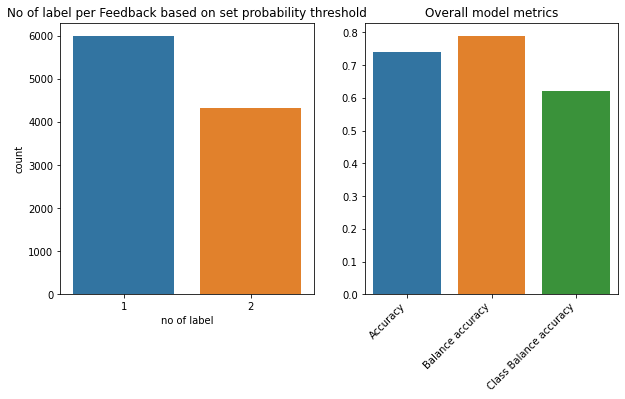

In [168]:
# Multi-label classification approach with oversampling
#==================================================== Each row probabilities don't neccesarily add up to 1 ====================================================
# %%time
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_word = set(stopwords.words('english'))
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import seaborn as sns

# Load in the data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.feedback.fillna('', inplace=True)

# Preprocess the single labelled dataset into a multilabel dataset and split the data into train and test set 
lb = LabelBinarizer().fit(df.label)
le = LabelEncoder().fit(df.label)    # create the label encoder object(needed for converting our prediction back to the text labels)
classes = lb.transform(df.label)
class_df = pd.DataFrame(classes, columns=lb.classes_)
df = pd.concat([df, class_df], axis=1)
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

# Address class imbalance in the training Dataset
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print('\n...Address class imbalance in the training Dataset')
X_train = np.array(train.feedback).reshape(-1, 1)         # RandomOverSampler require a 2D array 

# fit predictor and target variable
X_train, train_labels = RandomOverSampler(random_state=0).fit_resample(X_train, train.label)
proc_train = pd.DataFrame(np.column_stack([X_train, train_labels]),  columns=['feedback', 'label'])

# Explore number of samples in each class
print(f'Original dataset shape {Counter(train.label)}')
print(f'New dataset shape {Counter(proc_train.label)}')
print('='*40,'\n')

# # convert the training data to multiclass
train_classes = lb.transform(train_df.label)
train_class_df = pd.DataFrame(train_classes, columns=lb.classes_)
train = pd.concat([train_df, train_class_df], axis=1)
# #============================

# Define a pipeline combining a text feature extractor with multi lable classifier
LogReg_pipeline = Pipeline([
               ('tfidf', TfidfVectorizer(stop_words=stop_word)),
               ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
               ])

X_train = train.feedback
X_test = test.feedback
print('\nTraining the Model')
for category in lb.classes_:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))   # explore the model performance on the test data
    
    # print('\nPredicting probability on full dataset')
    all_prediction = LogReg_pipeline.predict(df.feedback)
    print('all data accuracy is {}'.format(accuracy_score(df[category], all_prediction))) # explore the model performance on all the data
    probs = LogReg_pipeline.predict_proba(df.feedback)[:,1]    # keep the probabilities for class 1
    df[category] = probs                      # extract the probabilities for label 1 = represent that the row belongs to the specified class
    print('='*40)

# Extract all probability as an array
all_pred_prob = df.iloc[:, -9:].values

# Multi-label prediction on the full dataset
print('\nPredicting for Multilabeling') 
high = 0.5
multilabel_counter = 0
label_counter = []
multilabel_rowindex = []
for i, p in enumerate(all_pred_prob): # itererate over each row 
  # set the threshold to be either high or the seventy-fifth percentile   
  seventh = np.percentile(p, [75]) 
  if max(p) > high:
    threshold = high
  else:
    threshold = seventh
  best_labels_dict = {k:v for k,v in enumerate(p) if v>threshold}    # extract  as a dictionary the index and values of probaility greater than the threshold percentage
  best_labels_id = sorted(best_labels_dict, key=best_labels_dict.get, reverse=True) # Extract the label code(best_labels_dict.keys) arranged in decreasing order of their probability values
  best_label = le.inverse_transform(best_labels_id)                  # convert the label code into the original class names   
  label_counter.append(len(best_label))      
  df.loc[i,'multi_label'] = ', '.join(best_label)

  if len(best_label) > 1:
      multilabel_counter+=1
      multilabel_rowindex.append(i)

print('Number of rows with MultiLabel is ', multilabel_counter) 
print('Maximum rowsum of probabilities is ', round(max(df.iloc[:, -9:].sum(axis=1)),2))    # To prove the probabilities across each row didn't auto add up to 1
print('='*40)

# Single Labeling 
print('\nPredicting for Single_labeling') 
predt = np.argmax(all_pred_prob, axis=-1)
predt = le.inverse_transform(predt)                  # convert the label code into the original class names   
df['Single_label'] = predt
print('='*40)

print('\n')
acc = round(accuracy_score(df['label'], predt), 2)
b_acc = round(balanced_accuracy_score(df['label'], predt), 2)
cl_bal_acc = round(class_balance_accuracy_score(df['label'], predt), 2)

print('Overall model accuracy is {}'.format(acc))   # explore the model performance on the test data
print('Overall model Balance accuracy is {}'.format(b_acc))   # explore the model performance on the test data
print('Overall model Class Balance accuracy is {}'.format(cl_bal_acc))   # explore the model performance on the test data
print('='*40)

# Visualization
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x=label_counter, ax=ax[0]).set(xlabel='no of label', title='No of label per Feedback based on set probability threshold')
sns.barplot(x=['Accuracy', 'Balance accuracy', 'Class Balance accuracy'], y=[acc, b_acc, cl_bal_acc], ax=ax[1]).set(title='Overall model metrics',)
plt.xticks(rotation = 45, ha='right')

# export the data
df.to_csv('MultiLa_data.csv')
df.head()